<a href="https://colab.research.google.com/github/nixXx13/jupyter-notebooks/blob/master/Pseudo_Labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Brief

Ive tried tackling the task of image classification of 120 dog breeds.
data included 10k labeled imgs and 10k test images without any label.

.


**The problem** - labeled training data isnt sufficient for achieving adequate model accuracy.

**possible solution** - Because test data is very large, using [pseudo labeling](http://deeplearning.net/wp-content/uploads/2013/03/pseudo_label_final.pdf) might help increase accuracy




**The problem 2** - keras's flow_from_directory uses the img directory as its label while we want to use our pseudo generated labels.

**possible solution 2** - implement our own generator so we can 'inject' our pseudo labels



## Setup
imports, data download and general functions declarations.

In [0]:
%pylab inline
import numpy as np

# importing utils from drive
from google.colab import drive
drive.mount('/content/drive')
UTILS_DRIVE_FNAMES = ['thirdPartyUtils.py' , 'py_utils.py']
UTILS_DRIVE_DIR = '/content/drive/My Drive/Colab Notebooks/Utils/'
for fname in UTILS_DRIVE_FNAMES:
  with open('{}{}'.format(UTILS_DRIVE_DIR,fname), 'r') as f:
    with open(fname,'w') as fw:
      fw.write(f.read())
    
from thirdPartyUtils import colab_utils
colab_utils(setupKaggle = True)

!pip install bcolz
from py_utils import *
# Pics inflation and dir oredering

!kaggle competitions download -c dog-breed-identification
HOME = '/content/dogBreed'

!unzip labels.csv.zip
import csv

mydict = csvToDict("labels.csv")
del mydict['id']

classes = list(set(mydict.values()))
makeDirs(classes,'/content/dogBreed')

Populating the interactive namespace from numpy and matplotlib
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Download 100%.
 === Kaggle setup succeeded!
     |████████████████████████████████| 1.5MB 2.9MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2661601 sha256=337187b65573e328efeb7e83b5725171a4edd5de4029c38dce64e5e4707e46a7
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
  0% 0.00

In [0]:
!unzip train.zip -d /content/dogBreed | wc -l
import shutil

trainDir = '/content/dogBreed/train'

!ls -l $trainDir/*.jpg | wc -l
i=0
for k in mydict.keys():
  shutil.move('{}/{}.jpg'.format(trainDir,k) , '{}/{}/{}.jpg'.format(trainDir,mydict[k],k))
  i+=1
  
print(' === moved {} files succesfully to train dir'.format(i))

10223
10222
 === moved 10222 files succesfully to train dir


In [0]:
from glob import glob
g = glob(HOME+"/train/*/*.jpg")
g_rand = np.random.permutation(g)

# VALID_NUM = 4000
VALID_NUM = 2000

i=0
for i in range(VALID_NUM):
  shutil.move(g_rand[i] , g_rand[i].replace('train','valid') )
  i+=1

print(' === moved {} files succesfully to valid dir'.format(i))

g_train = glob(HOME+'/train/*/*.jpg')
g_valid = glob(HOME+'/valid/*/*.jpg')

print(' === {} pics in train dirs'.format(len(g_train)))
print(' === {} pics in valid dirs'.format(len(g_valid)))

 === moved 2000 files succesfully to valid dir
 === 8222 pics in train dirs
 === 2000 pics in valid dirs


In [0]:
#unpacking test.zip to proper dir

testDir = "/content/dogBreed/test/unknown"
g_testDir = glob(testDir + "/*.jpg")

if len(g_testDir) == 0:
  !unzip test.zip -d /content/dogBreed/test | wc -l

  from glob import glob
  g = glob("/content/dogBreed/test/test/*.jpg")

  len(g)

  for img in g:
  #   print(img.replace("test/test","test/unknown"))
    shutil.move(img ,img.replace("test/test","test/unknown") )

  !ls -l /content/dogBreed/test/unknown | wc -l

  !rm -rf /content/dogBreed/test/test

10359
10358


In [0]:
import keras
# layers
from keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Convolution2D

# optimizers
from keras.optimizers import Adam

from keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from keras.layers.core import Lambda

def getVggTop():
  
  vgg = keras.applications.VGG16(weights = "imagenet", include_top=False,input_shape=(224,224,3))
  model = Sequential()
  model.add(Lambda(preprocess_input, input_shape=(224,224,3), output_shape=(224,224,3)))

  vgg_layers = vgg.layers
  vgg_layers.pop(0)
  for layer in vgg_layers:
    layer.trainable=False
    model.add(layer)
    
  return model

def getModel(
    do_cnn = 0.2,
    do_dense = 0.5,
    dense_width = 256,
    verbose = 0
  ):
  model = Sequential(
        getVggTop().layers + 
        [
         MaxPooling2D(),
         BatchNormalization(),
         Dropout(0.2),
         Flatten(),
         Dense(256,activation='relu'),
         BatchNormalization(),
         Dropout(0.4),
         Dense(120,activation='softmax')
        ]
   )
  print(model)
  print(model.summary()) if verbose else None
  return model

from keras.preprocessing import image
BS=64

def get_batch(
    dir,
    gen          = image.ImageDataGenerator(), 
    batch_size   = 64,
    shuffle      = True,
    target_size  = (224,224),
    class_mode   = 'categorical'
    ):
    return gen.flow_from_directory(dir,class_mode = class_mode,target_size=target_size,shuffle = shuffle,batch_size = batch_size )

def get_batches(fDir,
                gen = image.ImageDataGenerator(), 
                shuffle = False,
                batch_size = 64,
                class_mode = 'categorical',
                target_size= (224,224),
               ):
    str_shuffle = "train_shuffle".ljust(20," ")
    str_batch_size = "batch_size".ljust(20," ")
    str_class_mode = "class_mode".ljust(20," ")
    gen_id         = "gen used".ljust(20," ")
    str_target_size = "target_size".ljust(20," ")
    print("Creating batches with following params -\n{}:{}\n{}:{}\n{}:{}\n{}:{}\n{}:{}\n".format(str_shuffle,shuffle,str_batch_size,batch_size,str_class_mode,class_mode,gen_id,str(gen),str_target_size,str(target_size)))
    train_batch = get_batch(fDir + '/train',gen = gen,batch_size=batch_size,shuffle=shuffle,class_mode=class_mode,target_size=target_size)
    valid_batch = get_batch(fDir + '/valid',gen = gen,batch_size=batch_size,shuffle=False,class_mode=class_mode,target_size=target_size)
    test_batch  = get_batch(fDir + '/test',gen = gen,batch_size=batch_size,shuffle=False,class_mode=class_mode,target_size=target_size)
    
    return train_batch,valid_batch,test_batch

from keras.utils.np_utils import to_categorical    
        
def pyPlot(histList,pType=['acc','loss'],titleList = None):
  
    def getMaxValue(historyObj,plotType,prevMax):
      maxVal = max([max(historyObj.history['{}'.format(plotType)]) , max(historyObj.history['val_{}'.format(plotType)])])
      if prevMax>maxVal:
        return prevMax
      return maxVal
  
    def setDefaultTitles():
      titleList = []
      for i in range(len(histList)):
        titleList.append(str(i))
      return titleList
          
    if type(histList) != list:
      tmp = histList
      histList = []
      histList.append(tmp)
      
    if titleList != None:
      if len(titleList) != len(histList):
        print("Titles number !=  Hists number, Setting default titles")
        titleList = setDefaultTitles()
    
    else:
      titleList = setDefaultTitles()
          
    ncols = len(pType)
    plt.figure(figsize=(15,15))
    
    for i,pt in enumerate(pType):
      
      plt.subplot(2,ncols,i+1)
      plt.title(pt)
      plt.ylabel('{}'.format(pt))
      plt.xlabel('epoch')
      
      legend = []
      maxVal = 1

      for j,h in enumerate(histList):
        plt.plot(h.history['{}'.format(pt)])
        plt.plot(h.history['val_{}'.format(pt)])

        legend.append('train "{}"'.format(titleList[j]))
        legend.append('valid "{}"'.format(titleList[j]))
        
        maxVal = getMaxValue(h,pt,maxVal)

      plt.ylim(0,maxVal+0.2)
      plt.legend(legend,loc=0)
    plt.show()

Using TensorFlow backend.


## Generator implementation


In order to benefit from pseudo labeling, Pseudo labeled data vs regualar training labeled data should be in a certain ratio.

***mixIterator*** takes two iterators and wraps them as one iterator.
Ive used it to mix regualar training iterator with 48 batch size and pseudo labeled iterator of 16 batch size to achieve a 64 mixed iterator with a ratio of 25% pseudo labeled data.

In [0]:
class mixIterator():
  def __init__(self,itersList):
    self.itersList = itersList
    self.samples = sum([it.samples for it in itersList])
    print("mixIterator:Total number of imgs {}".format(self.samples))
   
  def reset(self):
    for it in self.itersList : it.reset 
  
  def __iter__(self):
    return self
  
  def __next__(self):
    a = next(self.itersList[0])
    b = next(self.itersList[1])
    imgs = np.concatenate((a[0],b[0]))
    labels = np.concatenate((a[1],b[1])) 

    return (imgs,labels)
  

***exteralLabelsIter*** (External Labels Iter).accepts external labels as argument to its constructor.
uses keras's flow_from_directory (with class_mode = None which returns solely imgs without any labels) and returns a label assosiated with it from the labels argument. 

In [0]:
class exteralLabelsIter():
  def __init__(self,directory,labels,
                      batch_size,
                      target_size = (224,224),
                      gen = image.ImageDataGenerator(), 
              ):
    self.imgIter = get_batch(directory,batch_size=int(batch_size),shuffle=False,class_mode=None,target_size=target_size,gen=gen)
    self.labels = np.concatenate([labels,labels]) # make room for extras
    self.labels_realSize = int(self.labels.shape[0]/2)
    self.BS = int(batch_size)
    self.firstIndex = 0
    if self.labels_realSize != self.imgIter.samples:
      raise Exception("exteralLabelsIter:Mismatch! Imgs number is {} and labels num is {}".format(self.imgIter.samples,self.labels_realSize))
    self.samples = self.imgIter.samples
  
  def reset(self):
    self.imgIter.reset()
    self.firstIndex = 0
  
  def __iter__(self):
    return self
  
  def __next__(self):
    imgs = next(self.imgIter)
    
    labels_num = imgs.shape[0] # equals self.Bs or less when reacing end of imgs list
    
    endIndex = self.firstIndex+labels_num
    if self.firstIndex>=self.labels_realSize and endIndex>=self.labels_realSize:
      self.firstIndex=int(self.firstIndex%self.labels_realSize)
      
    endIndex = self.firstIndex+labels_num
    
    labels = self.labels[self.firstIndex:endIndex]
    self.firstIndex = endIndex
    
    return (imgs,labels)

## Base model training


We will use base model weights as our starting point to the following training processes (which will run 10 addional epochs each):


*   Training a model using labeled data only.
 
*   Training a model using data with pseudo labeling ( as one hot vectors ) as described in the paper ( link in brief ).
* Training a model using data with pseudo labeling ( as probability vectors ).


training set has 8222 imgs, validation set is 2000.


Creating batches with following params -
train_shuffle       :True
batch_size          :64
class_mode          :categorical
gen used            :<keras.preprocessing.image.ImageDataGenerator object at 0x7f94fb96f358>
target_size         :(224, 224)

Found 8222 images belonging to 120 classes.
Found 2000 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.




58892288/58889256 [==============================] - 1s 0us/step








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
129/128 [==============================] - 182s 1s/step - loss: 3.0071 - acc: 0.2974 - val_loss: 1.7263 - val_acc: 0.5120
Epoch 2/10
129/128 [==============================] - 164s 1s/step - loss: 1.4977 - acc: 0.5824 - val_loss: 1.4689 - val_acc: 0.5765
Epoch 3/10
129/128 [==============================] - 166s 1s/s

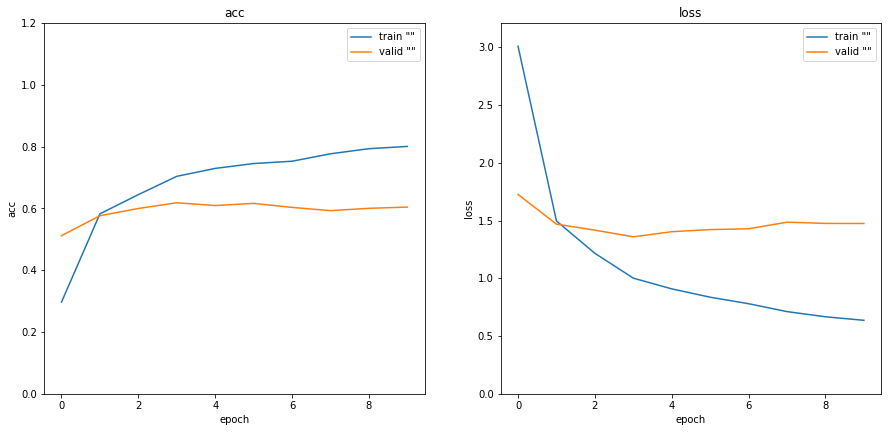

In [0]:
lr = 3e-3
EP = 10
hists = []
BS = 64
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True)

titles = [ "" ]


train_batch,valid_batch,test_batch = get_batches(HOME, shuffle=True, batch_size=BS,gen=gen)

train_classes = train_batch.classes
train_labels = to_categorical(train_batch.classes)
train_filenames = train_batch.filenames

val_classes = valid_batch.classes
val_labels = to_categorical(valid_batch.classes)
val_filenames = valid_batch.filenames

model = getModel()
model.compile(Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(train_batch,
                            steps_per_epoch = train_batch.samples/BS,
                            validation_data = valid_batch,
                            validation_steps = valid_batch.samples/BS,
                            epochs=EP)

hists.append(hist)

pyPlot(hists,titleList=titles)

model.save_weights("model.h5")

Validation set reached plateau ( not 100% because it keeps on decending but in a slow rate ) of loss around ~1.4 and accuracy around ~0.6

## Training data with labeled data only


In [0]:
model.load_weights("model.h5")
EP = 10
hist = model.fit_generator(train_batch,
                            steps_per_epoch = train_batch.samples/BS,
                            validation_data = valid_batch,
                            validation_steps = valid_batch.samples/BS,
                            epochs=EP)

Epoch 1/10
129/128 [==============================] - 178s 1s/step - loss: 0.6155 - acc: 0.8014 - val_loss: 1.4368 - val_acc: 0.6100
Epoch 2/10
129/128 [==============================] - 167s 1s/step - loss: 0.5517 - acc: 0.8216 - val_loss: 1.4993 - val_acc: 0.6125
Epoch 3/10
129/128 [==============================] - 166s 1s/step - loss: 0.5781 - acc: 0.8181 - val_loss: 1.5060 - val_acc: 0.6210
Epoch 4/10
129/128 [==============================] - 165s 1s/step - loss: 0.5575 - acc: 0.8280 - val_loss: 1.4871 - val_acc: 0.6270
Epoch 5/10
129/128 [==============================] - 165s 1s/step - loss: 0.5228 - acc: 0.8341 - val_loss: 1.4923 - val_acc: 0.6250
Epoch 6/10
129/128 [==============================] - 166s 1s/step - loss: 0.5009 - acc: 0.8407 - val_loss: 1.5460 - val_acc: 0.6105
Epoch 7/10
129/128 [==============================] - 166s 1s/step - loss: 0.4652 - acc: 0.8497 - val_loss: 1.5194 - val_acc: 0.6230
Epoch 8/10
129/128 [==============================] - 166s 1s/step - 

## Training data with pseudo labeling - as one hot vectors.
in addition to training set of 8222 imgs, a test set with pseudo labels of 10357 imgs is added to the training process.

ratio of training/pseudo imgs in a batch of 64 imgs is 75%/25%.

In [0]:
model.load_weights("model.h5")

BS = 64
_train_batch,_,_ = get_batches(HOME, shuffle=True, batch_size=int(3*(BS/4)),gen=gen)
_,_valid_batch,_test_batch = get_batches(HOME, batch_size=int(BS/4),gen=gen)


for i in range(10):
  pseudo_test_labels = model.predict_generator(_test_batch,_test_batch.samples/int(BS/4),verbose=1) 
  
  pseudo_test_labels_binary = np.zeros(pseudo_test_labels.shape)
  idxs = np.argmax(pseudo_test_labels,axis=1)

  numLabels = pseudo_test_labels.shape[0]
  pseudo_test_labels_binary[np.arange(numLabels),idxs]=1

  pseudo_test_batch = exteralLabelsIter(HOME + '/test',pseudo_test_labels_binary, batch_size=BS/4,gen=gen)
  mixedIter = mixIterator([_train_batch,pseudo_test_batch])

  EP = 1
  model.fit_generator(mixedIter,
                            steps_per_epoch = mixedIter.samples/BS,
                            validation_data = valid_batch,
                            validation_steps = valid_batch.samples/BS,
                            epochs=EP)

Creating batches with following params -
train_shuffle       :True
batch_size          :48
class_mode          :categorical
gen used            :<keras.preprocessing.image.ImageDataGenerator object at 0x7f94fb96f358>
target_size         :(224, 224)

Found 8222 images belonging to 120 classes.
Found 2000 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.
Creating batches with following params -
train_shuffle       :False
batch_size          :16
class_mode          :categorical
gen used            :<keras.preprocessing.image.ImageDataGenerator object at 0x7f94fb96f358>
target_size         :(224, 224)

Found 8222 images belonging to 120 classes.
Found 2000 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.
648/647 [==============================] - 180s 277ms/step
Found 10357 images belonging to 1 classes.
mixIterator:Total number of imgs 18579
Epoch 1/1
648/647 [==============================] - 181s 279ms/step
Found 10357 images belongin

## Training data with pseudo labeling - as probabily vectors.

In [0]:
model.load_weights("model.h5")

BS = 64
_train_batch,_,_ = get_batches(HOME, shuffle=True, batch_size=int(3*(BS/4)),gen=gen)
_,_valid_batch,_test_batch = get_batches(HOME, batch_size=int(BS/4),gen=gen)


for i in range(10):
  pseudo_test_labels = model.predict_generator(_test_batch,_test_batch.samples/int(BS/4),verbose=1) 

  pseudo_test_batch = exteralLabelsIter(HOME + '/test',pseudo_test_labels, batch_size=BS/4,gen=gen)
  mixedIter = mixIterator([_train_batch,pseudo_test_batch])

  EP = 1
  model.fit_generator(mixedIter,
                            steps_per_epoch = mixedIter.samples/BS,
                            validation_data = valid_batch,
                            validation_steps = valid_batch.samples/BS,
                            epochs=EP)

Creating batches with following params -
train_shuffle       :True
batch_size          :48
class_mode          :categorical
gen used            :<keras.preprocessing.image.ImageDataGenerator object at 0x7f94fb96f358>
target_size         :(224, 224)

Found 8222 images belonging to 120 classes.
Found 2000 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.
Creating batches with following params -
train_shuffle       :False
batch_size          :16
class_mode          :categorical
gen used            :<keras.preprocessing.image.ImageDataGenerator object at 0x7f94fb96f358>
target_size         :(224, 224)

Found 8222 images belonging to 120 classes.
Found 2000 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.
648/647 [==============================] - 188s 290ms/step
Found 10357 images belonging to 1 classes.
mixIterator:Total number of imgs 18579
Epoch 1/1
648/647 [==============================] - 189s 292ms/step
Found 10357 images belongin

## Summary!




*general note - 
I am putting aside the unsatisfactory accuracy of all models and mainly relate to conclusions regarding the psuedo labeling process.


**Comparison**
1. **regular trainging process**

  - test set - loss was decreasing from 0.6 to 0.43, accuracy from 0.8 to 0.86.

  - Validation set - loss incread to ~1.5 and best accuracy achieved is 0.627


2. **pseudo labeling ( as one hot vectors ) training process**

  - test set - loss jumped to ~1, as expected, and reached 0.55 at the end.

  - Validation set - loss oscilates in range 1.33-14.3. best valition accuracy is 0.65 in 9th epoch.

  - Note worth further checking - 
  
    Might be interesting to see that 9th epoch test accuracy is 0.827.if we look at 'regular model training' epochs we can see that epoch with close training accuracy reached validation accuracy of 0.827.
    
    If current training process will continue to train more epochs, it might get better validation accuracy when reaching 'regular model training' best training accuracy (which is 0.86).

3.  **pseudo labeling ( as probabily vectors ) training process**
  - test set - comparing to previous pseudo labeling method, loss is higher in ~0.2 and accuracy looks quite the same.

  - Validation set - comparing to previous pseudo labeling method, loss is slightly lower and accuracy is a bit lower.

**Conclusions and next steps**
- Pseudo labeling technique did show only slight improvements in loss and accuracy.

- Improvements might be more noticable if comparison will be based on training accuracy and not epochs number ( as mentioned above in comparision )
- It is worth checking different rations of labeled/pseusdo labeled imgs in a batch.

- Current pseudo labeling generator does not implement batch shuffeling!
Implementing shuffle might increase performance aswell.
